<a href="https://colab.research.google.com/github/LeyloJohnny/Cat_or_Dog/blob/main/WhoAmI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
#!pip install --upgrade torch torchvision
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [47]:
key = os.environ.get('AZURE_SEARCH_KEY', '854cf690bd9c4537983454f3579c12ee')

In [98]:
bear_types = 'grizzly','teddy'
path = Path('bear')

In [97]:
#shutil.rmtree(path)

In [99]:
if not path.exists():
  path.mkdir()
  for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} bear')
    download_images(dest, urls=results.attrgot('contentUrl'))

In [100]:
fns = get_image_files(path)
fns

(#268) [Path('bear/teddy/00000051.jpg'),Path('bear/teddy/00000071.jpg'),Path('bear/teddy/00000070.png'),Path('bear/teddy/00000138.jpg'),Path('bear/teddy/00000135.jpg'),Path('bear/teddy/00000107.jpg'),Path('bear/teddy/00000062.jpg'),Path('bear/teddy/00000129.jpg'),Path('bear/teddy/00000024.jpg'),Path('bear/teddy/00000100.jpg')...]

In [101]:
failed = verify_images(fns)
failed

(#6) [Path('bear/teddy/00000077.png'),Path('bear/teddy/00000142.png'),Path('bear/teddy/00000141.jpg'),Path('bear/grizzly/00000111.jpg'),Path('bear/grizzly/00000036.jpg'),Path('bear/grizzly/00000116.jpg')]

In [102]:
failed.map(Path.unlink);

In [103]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [105]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [107]:
dls = bears.dataloaders(path)

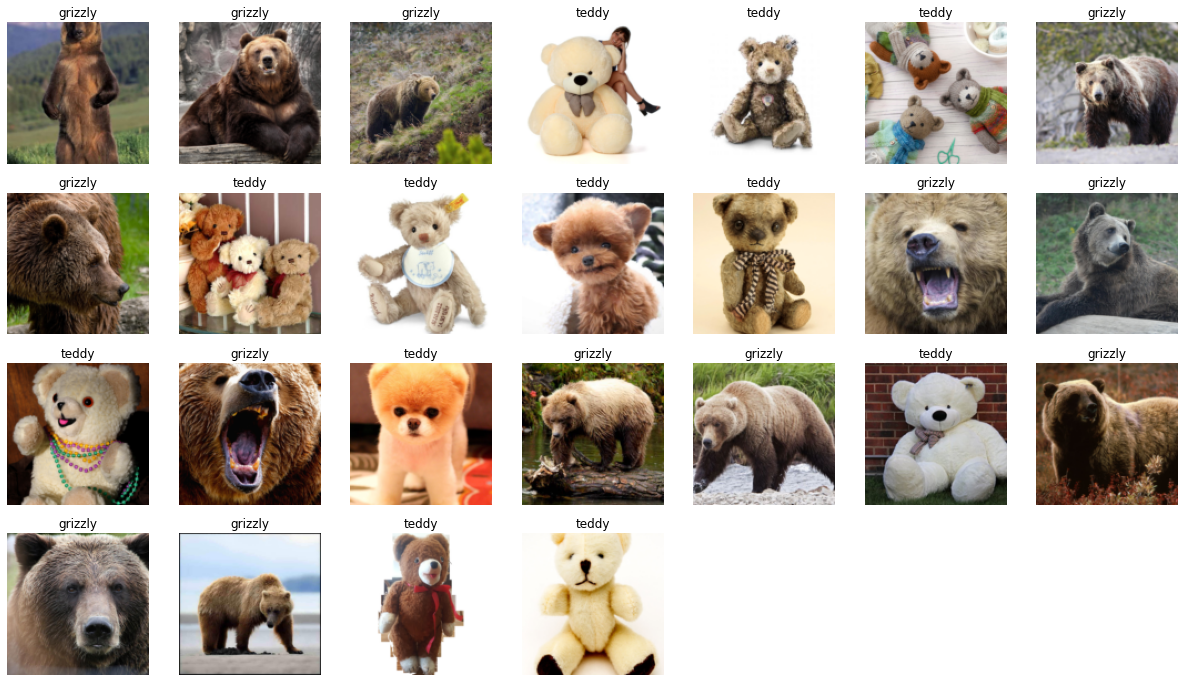

In [108]:
#not necessary
dls.valid.show_batch(max_n=25, nrows=4)

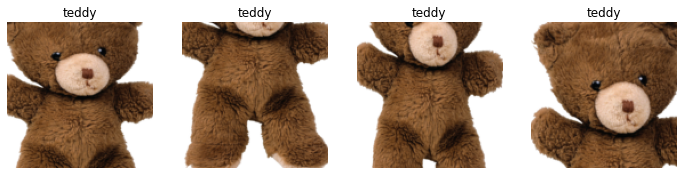

In [109]:
#not necessary
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

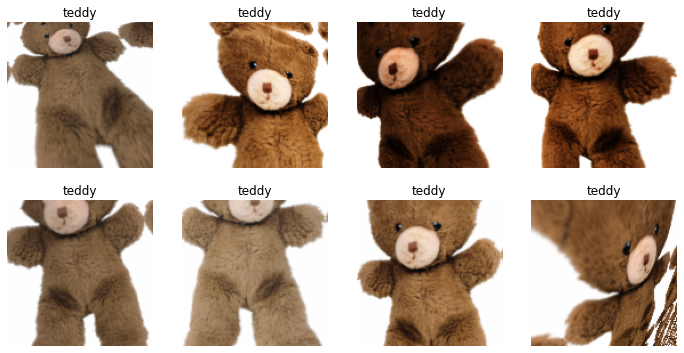

In [111]:
#not necessary
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [112]:
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [113]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.036540,0.010328,0.000000,00:40


epoch,train_loss,valid_loss,error_rate,time
0,0.082502,0.004754,0.000000,00:50
1,0.049666,0.004849,0.000000,00:50
2,0.032800,0.008087,0.000000,00:49
3,0.024011,0.012928,0.000000,00:49


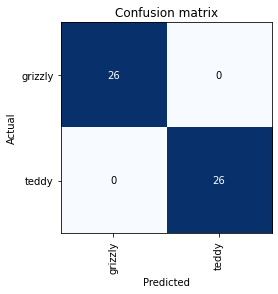

In [114]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

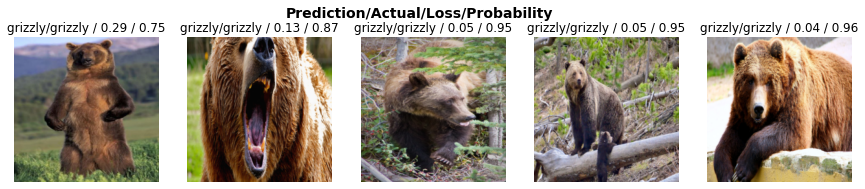

In [115]:
interp.plot_top_losses(5, nrows=1)

In [116]:
learn.export()

In [117]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [118]:
learn_inf = load_learner(path/'export.pkl')

In [121]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [125]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [127]:
pred,pred_idx,probs = learn_inf.predict(img)

In [128]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 1.0000')

In [129]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [130]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [137]:
btn_upload = widgets.FileUpload()

In [138]:
VBox([widgets.Label('Select your bear!'), 
      test_btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila 